# Salut le projo


In [1]:
import autograd
from autograd import numpy as np
import matplotlib.pyplot as plt

Les fonctions bien pratiques : 

- distance permet de calculer les distances entre deux points a et b

- perpendicular rend la normal à un vecteur (un point en fait) (direction arbitraire)

In [2]:
def distance(a, b) :
    return ((a[0] - b[0])**2 + (a[1]-b[1])**2 ) ** 0.5

def perpendicular( a ) :
    b = np.array([-a[1], a[0]])
    return b


Je définis la fonction contrainte qui impose la distance delta entre deux points du tracé de notre ligne de niveau

In [3]:
def contrainte(a,b,delta):
    return distance(a,b) - delta

La fonction F qui va de R^2 dans R^2, qui lorsqu'elle s'annule :

- vérifie avec sa première coordonnée que le point est bien sur la ligne de niveau f(x,y)=c

- s'assure que le nouveau point créé ,b , est à la distance delta du point précédent de la ligne de niveau, a

Cette fonction permettra par la suite d'utiliser la méthode de newton...

In [4]:
def F(a, b, c, delta, f):
    return(np.array[[f(b[0],b[1])-c],[contrainte(a, b, delta)]])

In [5]:
def find_seed(g, c=0, eps = 2**(-26)) :
    # On cherche le réel t tq f(0,t) = c par dichotomie
    a = 0
    b = 1
    if not (g(a) <= c <= g(b) or g(a) >= c >= g(b)) :
        return None
    while b-a > 2*eps :
        t = (b+a) / 2
        if g(t) > c :
            b = t
        elif g(t) < c :
            a = t
        elif g(t) == c :
            return t
    return (b+a) / 2

#NB : Ici la condition "raisonnable" provient du TVI : c compris entre f(0,1) et f(0,0) => t existe

Ici les fonctions gradient et Jacobienne, recopiée directement du poly

In [6]:
def grad_f(f,x,y) :
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]

def Jacob(F, x, y) :
    j = autograd.jacobian
    return np.c_[j(F, 0)(x, y), j(F, 1)(x, y)]

In [25]:
def simple_contour(f, c=0.0, delta=0.01, eps = 2**(-26)) :

    def g(y) :
        return f(0, y)

    if find_seed(g, c) == None :
        return [], []

    X = [0.0]
    Y = [find_seed(g, c)]
    tg = perpendicular(grad_f(f, X[0], Y[0]))
    if tg[0] >= 0 :
        X.append(tg[0])
        Y.append(tg[1])
    else :
        X.append(-tg[0])
        Y.append(-tg[1])

    while not fin_ligne(X, Y, delta) :
        gradient = grad_f(X[-1], Y[-1])
        perp = perpendicular(gradient)
        tg = (perp / np.linalg.norm(perp)) * delta
        adernier = [X[-2], Y[-2]]
        dernier = [X[-1],Y[-1]]
        
        if distance(adernier, dernier + tg) >= distance(adernier, dernier - tg) :
            newton0 = dernier + tg
        else :
            newton0 = dernier - tg
            
        suivant = Newton(f, newton0, dernier, c, delta, eps)
        X.append(suivant[0])
        Y.append(suivant[1])
    
    return X, Y
    # Il reste alors à plotter la ligne de niveau
            
            
def Newton(f, newton0, dernier, c, delta, eps = 2**(-26)) :
    newton_k = newton0
    while F(newton_k, dernier, c, delta, f)[0] > eps and F(newton_k, dernier, c, delta, f)[1] > eps :
        J_inv = np.linalg.inv(Jacob(F, newton_k[0], newton_k[1]))
        newton_k = newton_k - np.dot(J_inv, F(newton_k, dernier, c, delta, f))
    return newton_k
                
def fin_ligne(X, Y, delta) :
    if X[-1] > 1 - delta/2 or X[-1] < delta/2 or Y[-1] > 1 - delta/2 or Y[-1] < delta/2 :
        return True
    if distance([X[0], Y[0]], [X[-1], Y[-1]]) < delta/2 :
        return True
    return False
        



In [8]:
def f(x, y) : # Fonction du poly
    return 2 * (np.exp(-x**2 - y**2) - np.exp(-(x-1)**2 - (y-1)**2))

def Test_jacob(x, y) :
    return np.array([[2*np.exp(x)], [np.exp(y)]])

def test_simple(x,y) :
    return x**2 + y**2

[0.0, 1.5999999940395355] [0.7999999970197678, -0.0]


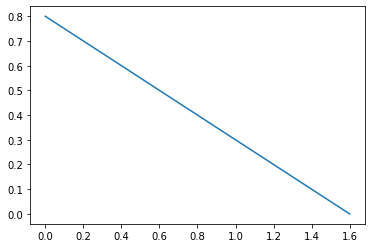

In [26]:
les_x, les_y = simple_contour(test_simple, c = 0.64, delta = 0.001)
print(les_x, les_y)
plt.plot(les_x, les_y)